In [ ]:
!pip install "gluonts[torch]"

In [ ]:
!pip install "gluonts[mxnet]"

In [ ]:
!pip install ucimlrepo

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from gluonts.dataset.pandas import PandasDataset
from gluonts.dataset.split import split
from gluonts.torch import DeepAREstimator

/usr/local/lib/python3.10/dist-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [ ]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
air_quality = fetch_ucirepo(id=360)


In [ ]:
df = air_quality.data.features.copy()
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

# Set 'Datetime' as the index
df.set_index('Datetime', inplace=True)

# Optionally, you can drop the original 'Date' and 'Time' columns if they are no longer needed
df.drop(columns=['Date', 'Time'], inplace=True)
df = df[['CO(GT)']]
df = df.rename({'CO(GT)':'CO'}, axis=1)
df[df['CO'] == -200] = np.nan

In [ ]:
df.to_csv('/content/air_data.csv')

In [ ]:
df.interpolate(method = 'linear', inplace=True)

In [ ]:
df.index.max()

Timestamp('2005-04-04 14:00:00')

In [ ]:
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (20, 3)

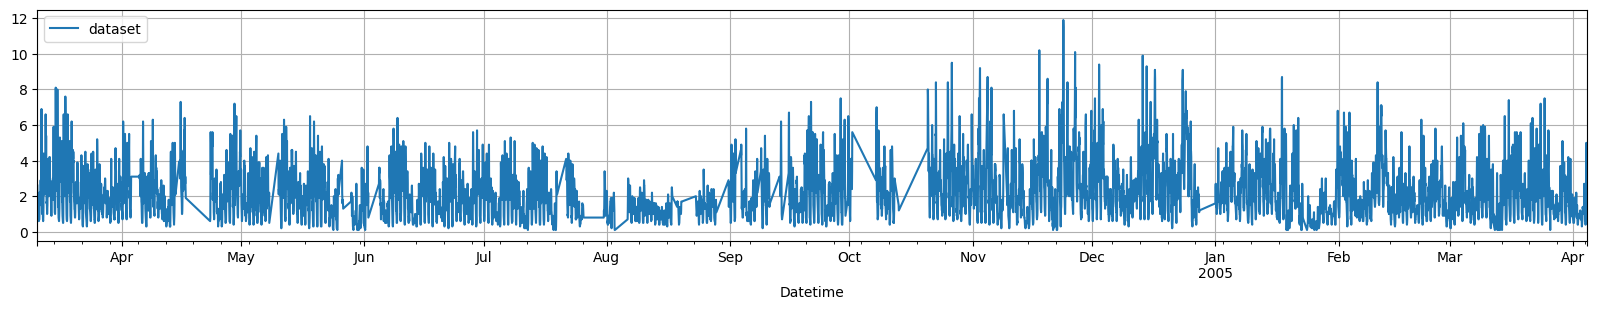

In [ ]:
df.plot()
plt.legend(["dataset"], loc="upper left")
plt.show()

In [ ]:
dataset = PandasDataset(df, target="CO")

In [ ]:
from gluonts.dataset.util import to_pandas


def highlight_entry(entry, color):
    start = entry["start"]
    end = entry["start"] + len(entry["target"])
    plt.axvspan(start, end, facecolor=color, alpha=0.2)


def plot_dataset_splitting(original_dataset, training_dataset, test_pairs):
    for original_entry, train_entry in zip(original_dataset, training_dataset):
        to_pandas(original_entry).plot()
        highlight_entry(train_entry, "red")
        plt.legend(["sub dataset", "training dataset"], loc="upper left")
        plt.show()

    for original_entry in original_dataset:
        for test_input, test_label in test_pairs:
            to_pandas(original_entry).plot()
            highlight_entry(test_input, "green")
            highlight_entry(test_label, "blue")
            plt.legend(["sub dataset", "test input", "test label"], loc="upper left")
            plt.show()

In [ ]:
training_periods = trainin_dataset

In [ ]:
type(training_dataset)

gluonts.dataset.split.TrainingDataset

In [ ]:
list(model.predict(df))

AttributeError: 'str' object has no attribute 'copy'

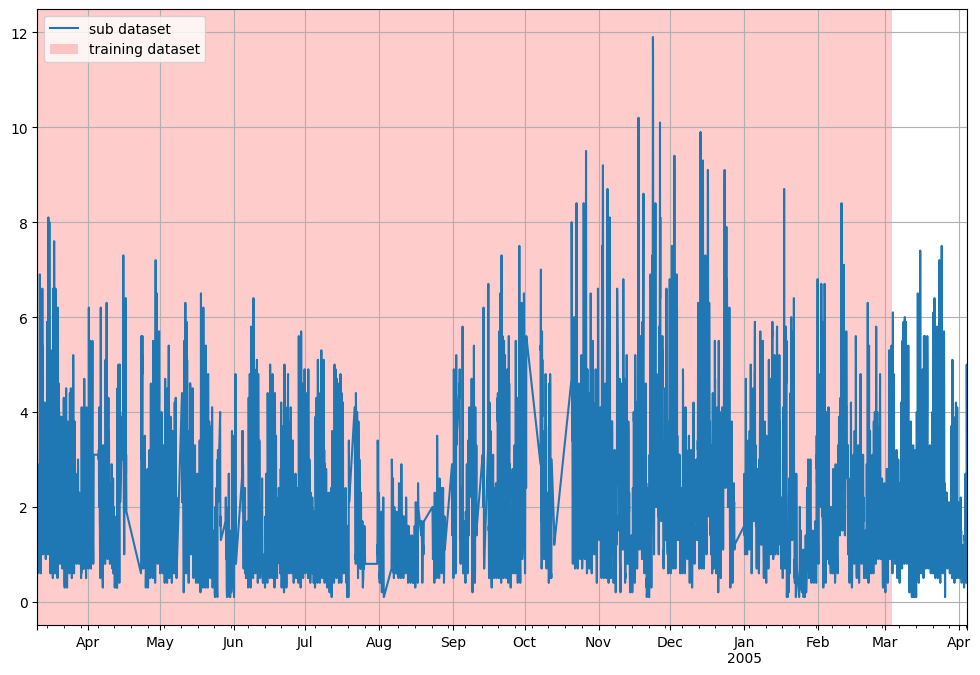

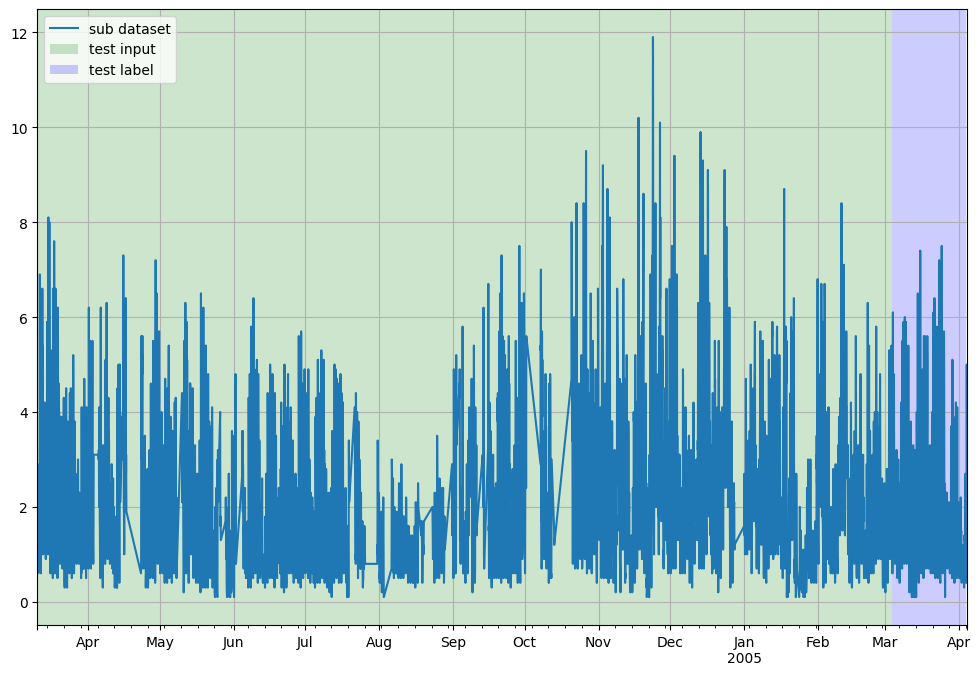

In [ ]:
prediction_length = 31 * 24
training_dataset, test_template = split(
    dataset, date=pd.Period("2005-03-04 00:00:00", freq="1H")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=1,
)

plot_dataset_splitting(dataset, training_dataset, test_pairs)

In [ ]:
from gluonts.mx.trainer import Trainer
from gluonts.evaluation import Evaluator, make_evaluation_predictions
from gluonts.torch import DeepAREstimator


model = DeepAREstimator(
    prediction_length=24*31, freq="h", num_layers = 3, trainer_kwargs={"max_epochs": 50}
).train(training_dataset)

INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
INFO: You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#t

Training: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 50: 'train_loss' reached 1.83163 (best 1.83163), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 0, global step 50: 'train_loss' reached 1.83163 (best 1.83163), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=0-step=50.ckpt' as top 1
INFO: Epoch 1, global step 100: 'train_loss' reached 1.39354 (best 1.39354), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 1, global step 100: 'train_loss' reached 1.39354 (best 1.39354), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=1-step=100.ckpt' as top 1
INFO: Epoch 2, global step 150: 'train_loss' reached 0.87823 (best 0.87823), saving model to '/content/lightning_logs/version_0/checkpoints/epoch=2-step=150.ckpt' as top 1
INFO:lightning.pytorch.utilities.rank_zero:Epoch 2, global step 150: '

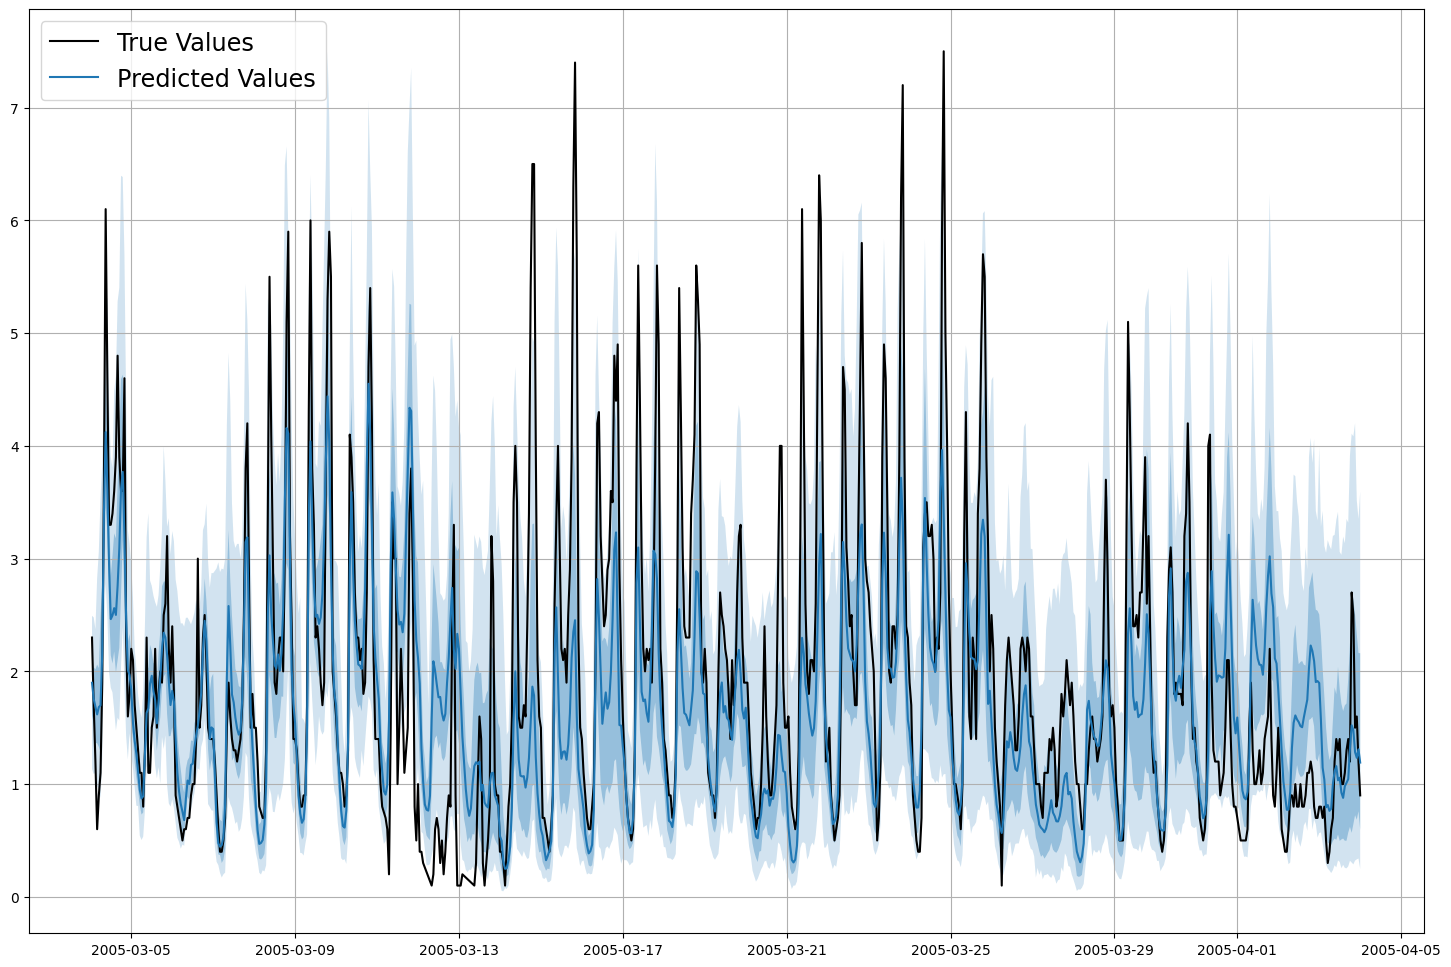

In [ ]:
forecasts = list(model.predict(test_pairs.input))

time_index = pd.date_range("2005-03-04 01:00:00", periods=744, freq="H")
forecast_series = pd.Series(index=time_index)
forecast_series[:] = forecasts[0].mean

plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (18, 12)
start_date = pd.Timestamp('2005-03-04 01:00')
end_date = start_date + pd.DateOffset(hours=forecasts[0].prediction_length-1)
# Plot predictions
plt.plot(df[start_date:end_date], color="black")
for forecast in forecasts:
  forecast.plot()
plt.legend(["True Values", "Predicted Values"], loc="upper left", fontsize="xx-large")
plt.show()

In [ ]:
def evaluate_model(true_values, predicted_values, num_params):
    # Calculate MAE
    mae = np.mean(np.abs(true_values - predicted_values))

    # Calculate RMSE
    rmse = np.sqrt(np.mean((true_values - predicted_values) ** 2))

    # Calculate AICc
    n = len(true_values)  # Number of data points
    rss = np.sum((true_values - predicted_values) ** 2)  # Residual sum of squares
    aic = n * np.log(rss / n) + 2 * num_params
    aicc = aic + (2 * num_params * (num_params + 1)) / (n - num_params - 1)

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"AICc: {aicc}")

# Extract true values from the original dataset for the prediction period
# notice that we scale the data back here
start_date = pd.Timestamp('2005-03-04 01:00')
end_date = start_date + pd.DateOffset(hours=forecasts[0].prediction_length-1)
true_values = df[start_date:end_date]["CO"].values

# Extract predicted values
predicted_values = np.concatenate([forecast.mean for forecast in forecasts], axis=0)

# Number of parameters in the model
num_params = sum(p.numel() for p in model.network.parameters())

# Evaluate the model
evaluate_model(true_values, predicted_values, num_params)




MAE: 0.6785505558454221
RMSE: 0.9668147854584399
AICc: -1565.842622395212


In [ ]:
forecasts[0].mean.shape

(744,)

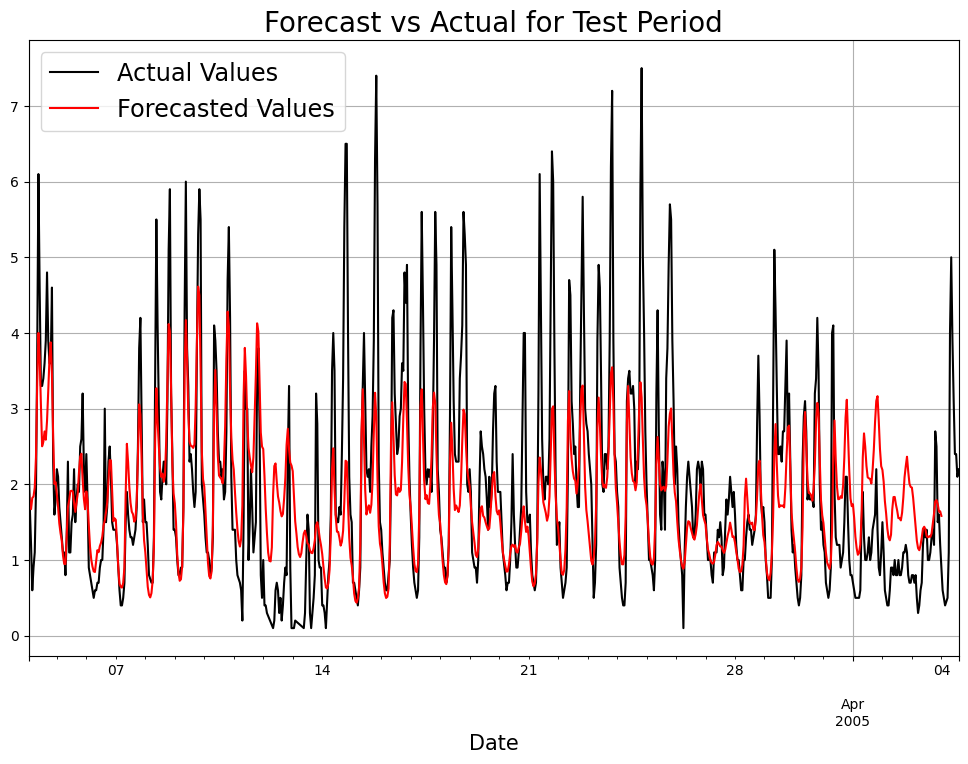

In [ ]:
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12, 8)

time_index = pd.date_range("2005-03-04 01:00:00", periods=744, freq="H")
series = pd.Series(index=time_index)
series[:] = forecasts[0].mean

# Plot the two series with specified colors and labels
ax = df.CO[start_date:].plot(label='CO', color='black')
series.plot(ax=ax, label='Forecast', color='red')

# Add a legend
plt.xlabel("Date", fontsize=15)
plt.title("Forecast vs Actual for Test Period", fontsize = 20)
plt.legend(["Actual Values", "Forecasted Values"], loc="upper left", fontsize="xx-large")
# Show the plot
plt.show()

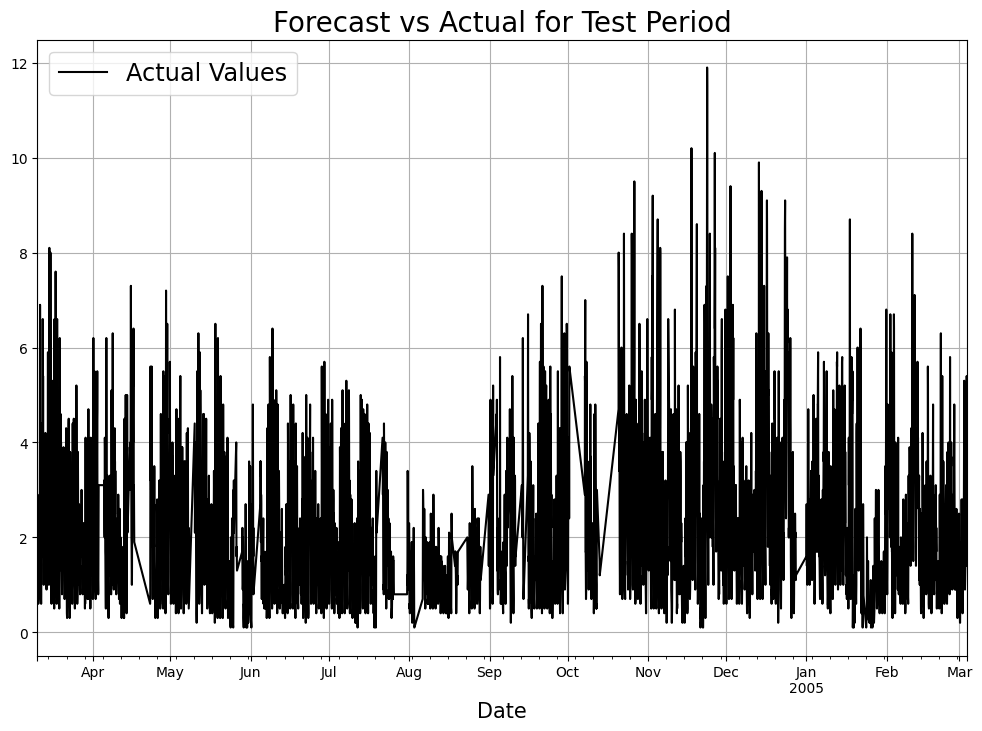

In [ ]:
df[:start_date].plot(label = 'Actual', color='black')
# Add a legend
plt.xlabel("Date", fontsize=15)
plt.title("Forecast vs Actual for Test Period", fontsize = 20)
plt.legend(["Actual Values", "Fitted"], loc="upper left", fontsize="xx-large")
# Show the plot
plt.show()

In [ ]:
dates = [
    "2004-04-04 00:00:00",
    "2004-05-04 00:00:00",
    "2004-06-04 00:00:00",
    "2004-07-04 00:00:00",
    "2004-08-04 00:00:00",
    "2004-09-04 00:00:00",
    "2004-10-04 00:00:00",
    "2004-11-04 00:00:00",
    "2004-12-04 00:00:00",
    "2005-01-04 00:00:00",
    "2005-02-04 00:00:00"
]

plot_


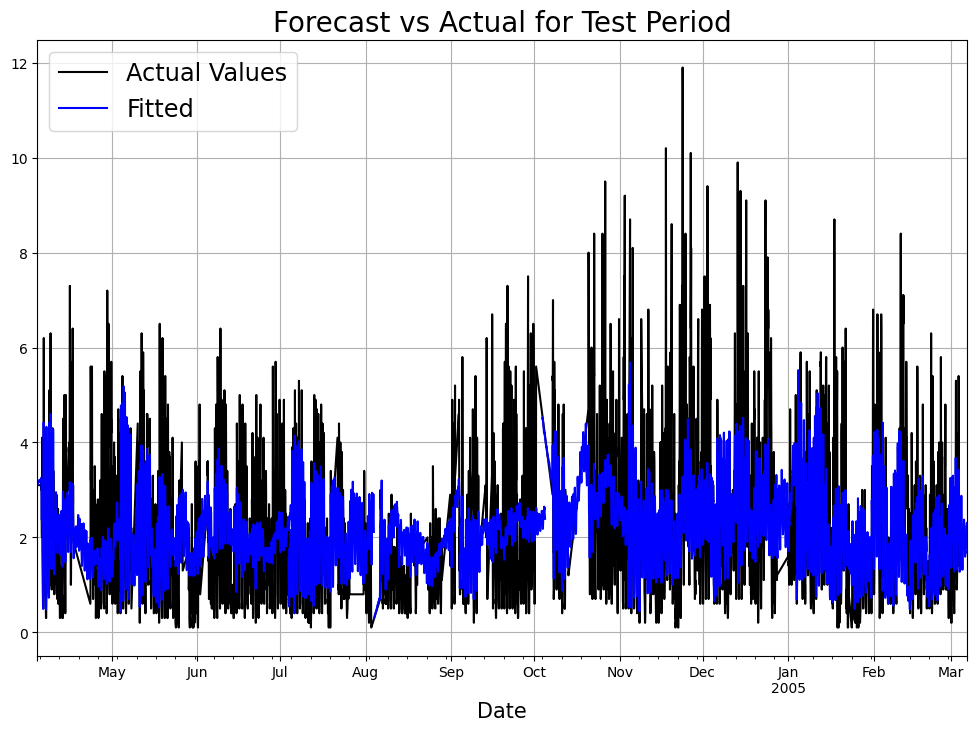

In [ ]:
plt.rcParams["axes.grid"] = True
plt.rcParams["figure.figsize"] = (12, 8)

ax = df[dates[0]:start_date].plot(label='Actual', color='black')

# Iterate through the test periods and plot fitted values
for time in dates:
    # Split dataset for the current time period
    _, test_template = split(dataset, date=pd.Period(time, freq="1H"))

    # Generate test pairs
    test_pairs = test_template.generate_instances(
        prediction_length=prediction_length,
        windows=1,
    )

    # Predict
    temp = list(model.predict(test_pairs.input))

    # Create time index for the forecast period
    time_index = pd.date_range(time, periods=744, freq="H")

    # Create series for the forecast
    temp_series = pd.Series(index=time_index)
    temp_series[:] = temp[0].mean

    # Plot the forecasted series on the same axes
    temp_series.plot(ax=ax, label='Fitted', color='blue')

# Add title, labels, legend, and show the plot
plt.xlabel("Date", fontsize=15)
plt.title("Forecast vs Actual for Test Period", fontsize=20)
plt.legend(["Actual Values", "Fitted"], loc="upper left", fontsize="xx-large")
plt.show()

In [ ]:
series1 = pd.Series([1, 2, 3], index=['a', 'b', 'c'])
series2 = pd.Series([4, 5, 6], index=['d', 'e', 'f'])

# Concatenate the series
combined_series = pd.concat([series1, series2])

print(combined_series)

a    1
b    2
c    3
d    4
e    5
f    6
dtype: int64


In [ ]:
prediction_length = 31 * 24
_, test_template = split(
    dataset, date=pd.Period("2004-03-04 00:00:00", freq="1H")
)
test_pairs = test_template.generate_instances(
    prediction_length=prediction_length,
    windows=1,
)

In [ ]:
time_index = pd.date_range("2005-03-04 01:00:00", periods=744, freq="H")
series = pd.Series(index=time_index)
series[:] = forecasts[0].mean

In [ ]:
df.index.min()

Timestamp('2004-03-10 18:00:00')